In [1]:
import cv2
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact

/Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/marknuzhnov/miniforge3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6), dpi=350)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [56]:
img = cv2.cvtColor(cv2.imread('1.jpeg'), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray,(9,9),0)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,55,7)

In [ ]:
plot_img(thresh)

In [ ]:
sld1 = IntSlider(value=5, min=1, max=100, step=2, continuous_update=False)
sld2 = IntSlider(value=1, min=1, max=10, step=1, continuous_update=False)


def vary_thresh_parameters(kernel_size, C):
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,kernel_size,C)
    plot_img(edges)

In [ ]:
interact(vary_thresh_parameters, kernel_size=sld1, C=sld2);

In [ ]:
output = thresh.copy()
circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, 1.2, 100)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
plot_img(output)

In [ ]:
def get_shape(approx):
    if len(approx) == 3:
        shape = "triangle"
    elif len(approx) == 4:
#         (x, y, w, h) = cv2.boundingRect(approx)
        
        area = cv2.contourArea(approx)
        perimeter = cv2.arcLength(approx, True) 
        ar = area * 16 / perimeter**2
        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
    else:
        shape = "circle"
    return shape

In [ ]:
!pip install imutils

In [54]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# construct the argument parse and parse the arguments


def view():
	boundaries = [([100, 0, 0], [255, 200, 190])]
	
	img = []
    
	for (lower, upper) in boundaries:
		# create NumPy arrays from the boundaries
		lower = np.array(lower, dtype = "uint8")
		upper = np.array(upper, dtype = "uint8")
 
		# find the colors within the specified boundaries and apply
		# the mask
		mask = cv2.inRange(image, lower, upper)
		output = cv2.bitwise_and(image, image, mask = mask)
		area(output)
		img.append(output)

		#cv2.imshow("images", np.hstack([image, output]))
		#cv2.waitKey(0)
	area(img)


def area(img):
    #cv2.imshow("Input",img)
    #cv2.waitKey(0)
    img1 = np.uint8(img)
    edged = cv2.Canny(img1, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #(cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None

    total_area = 0
    base = 0
    
    cnts = sorted(cnts, key=lambda x: -cv2.contourArea(x))
    for c in cnts[:3]:
        orig = img.copy()
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")


        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

            
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)


        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)


        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
                 (255, 0, 255), 2)

        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
                 (255, 0, 255), 2)

        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / 1

            # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        area = cv2.contourArea(c)
        
        font = cv2.FONT_HERSHEY_SIMPLEX 
        org = (0, 185)
        fontScale = 1 
        color = (0, 0, 255)

        print("Area is {}".format(area))

        plot_img(orig)



Area is 1127947.0


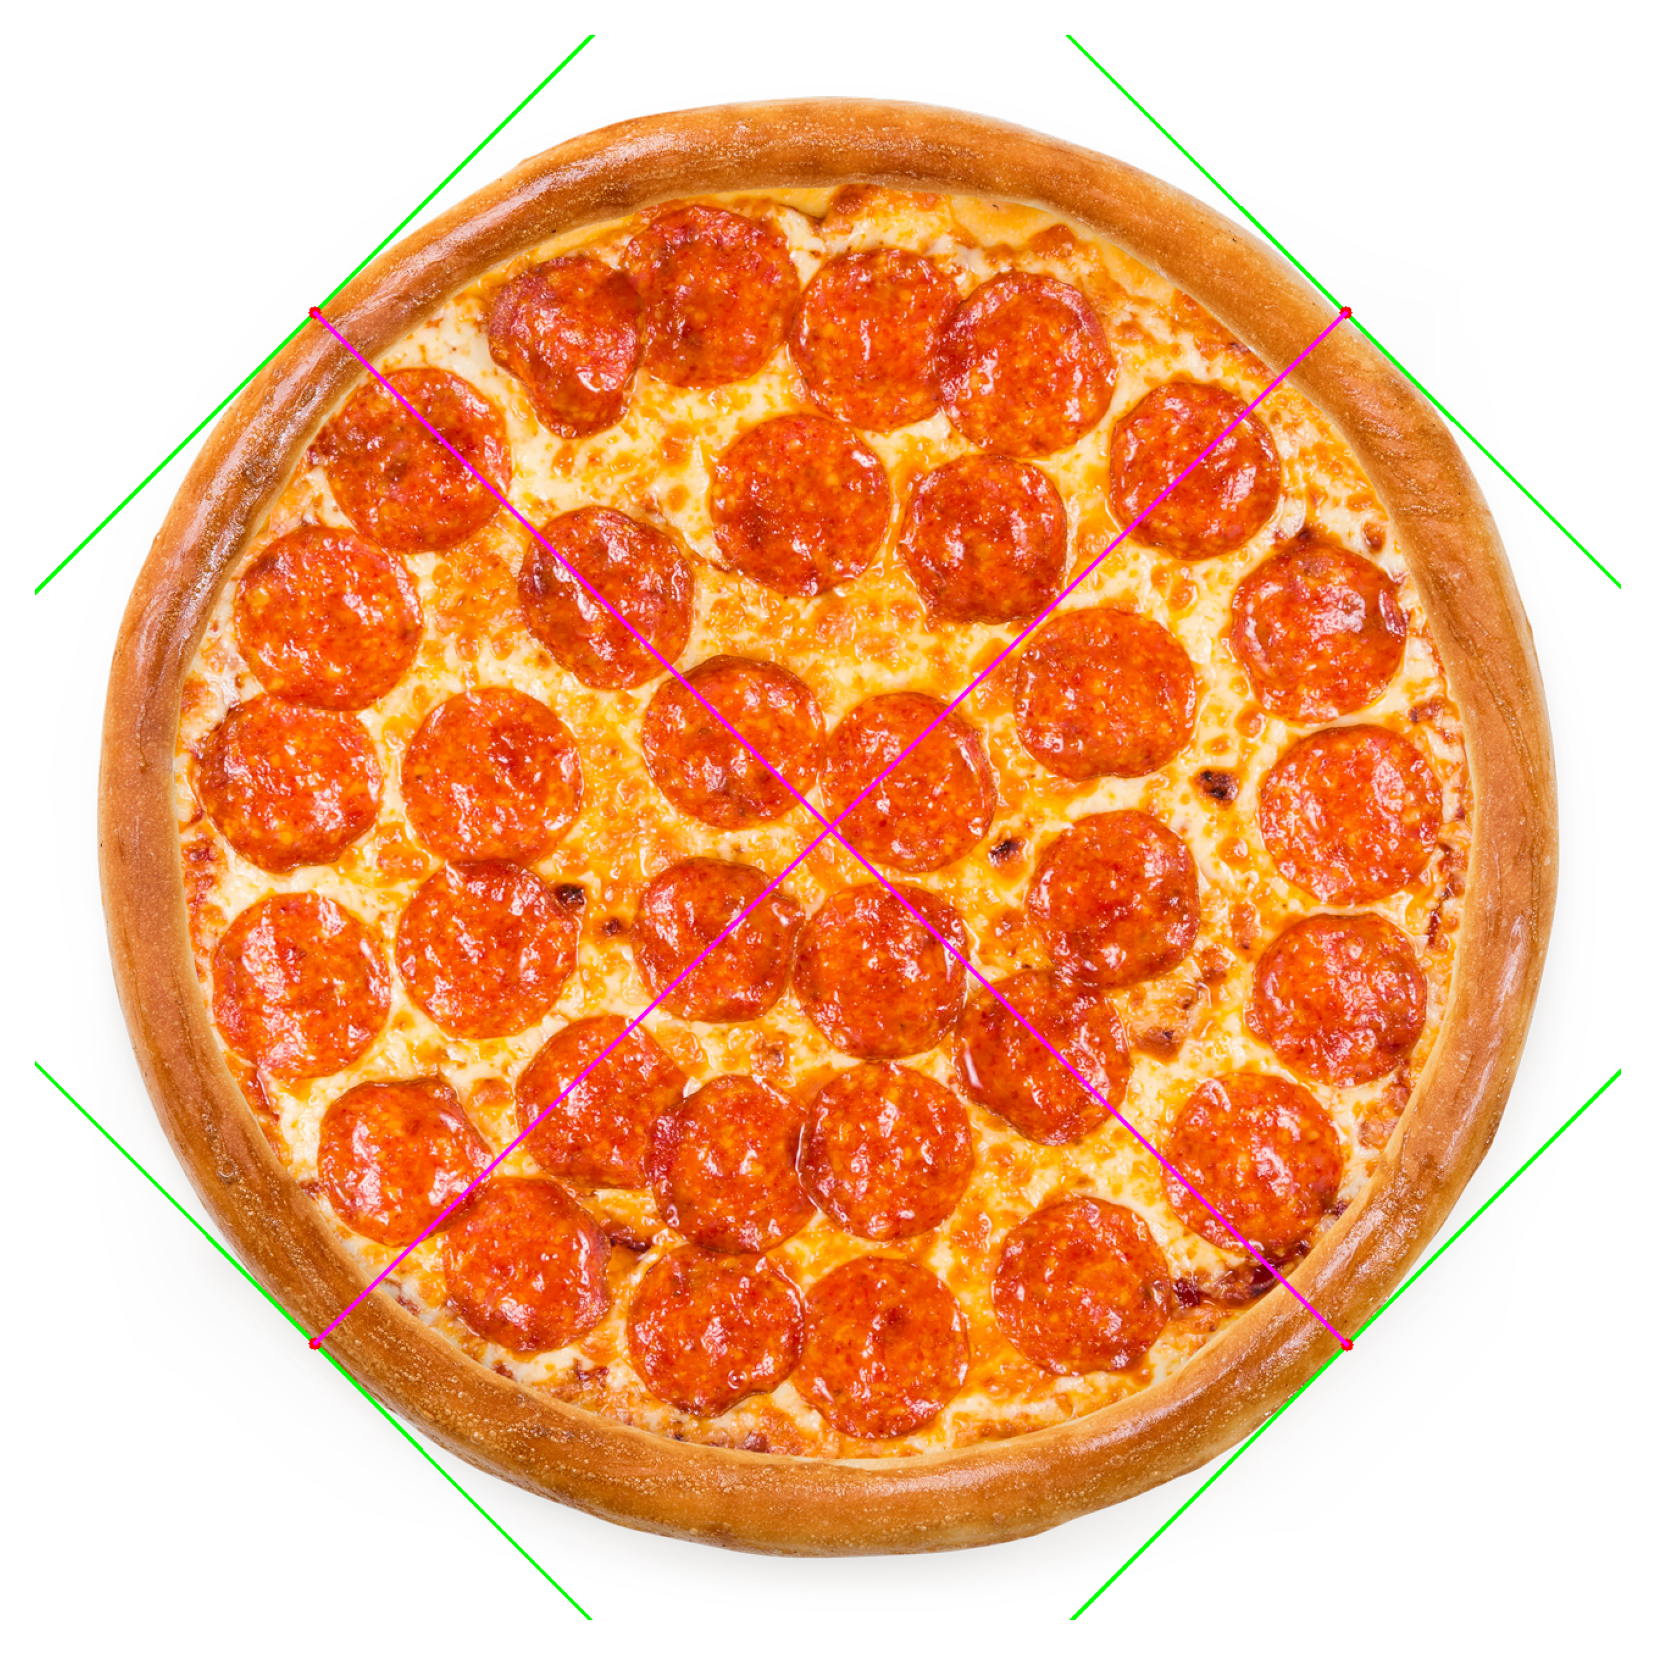

In [57]:
area(img)

In [49]:
x = [1, 3, 2, 8, 12, 5, 6]

In [50]:
x.sort()

In [51]:
x

[1, 2, 3, 5, 6, 8, 12]